In [26]:
import json
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import joblib

In [29]:
# -------------------------------
# Cargar dataset JSONL
# -------------------------------
def load_jsonl(file_path):
    texts = []
    labels = []
    tipos = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            data = json.loads(line)
            texts.append(data["texto"])
            labels.append(data["clase"])
            tipos.append(data["tipo"])
    return texts, labels, tipos

In [30]:
# Ruta del archivo jsonl
file_path = 'capitulos_base_100_completo.jsonl'
texts, labels, tipos = load_jsonl(file_path)

In [31]:
# -------------------------------
# Métrica simple de cantidad por clase y tipo
# -------------------------------
df_conteo = pd.DataFrame({
    "clase": labels,
    "tipo": tipos
})

conteo = df_conteo.value_counts().reset_index(name='cantidad')

print("\nCantidad de textos por clase y tipo:")
print(conteo)


Cantidad de textos por clase y tipo:
    clase    tipo  cantidad
0      ia  cuento        38
1      ia   libro        34
2  humano   libro        32
3      ia  ensayo        32
4  humano  ensayo        18
5  humano  cuento        18


In [32]:
# -------------------------------
# Cargar modelo BERT y tokenizer
# -------------------------------
from transformers import BertTokenizer, BertModel
import torch
import numpy as np

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

def embed_texts(text_list):
    embeddings = []
    for text in text_list:
        tokens = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
        with torch.no_grad():
            outputs = bert_model(**tokens)
        emb = outputs.pooler_output[0].numpy()
        embeddings.append(emb)
    return np.array(embeddings)

X = embed_texts(texts)
y = np.array(labels)

In [33]:
# -------------------------------
# Entrenamiento con K-Fold Cross Validation y Grid Search
# -------------------------------
param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2]
}

rf = RandomForestClassifier(random_state=42)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=cv,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X, y)

best_model = grid_search.best_estimator_
best_params = grid_search.best_params_
cv_score = grid_search.best_score_

print("Mejores hiperparámetros:", best_params)
print("Mejor F1 macro promedio:", cv_score)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Mejores hiperparámetros: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}
Mejor F1 macro promedio: 0.828499195988677



Reporte de clasificación:
              precision    recall  f1-score   support

      humano       0.85      0.74      0.79        68
          ia       0.84      0.91      0.88       104

    accuracy                           0.84       172
   macro avg       0.84      0.82      0.83       172
weighted avg       0.84      0.84      0.84       172



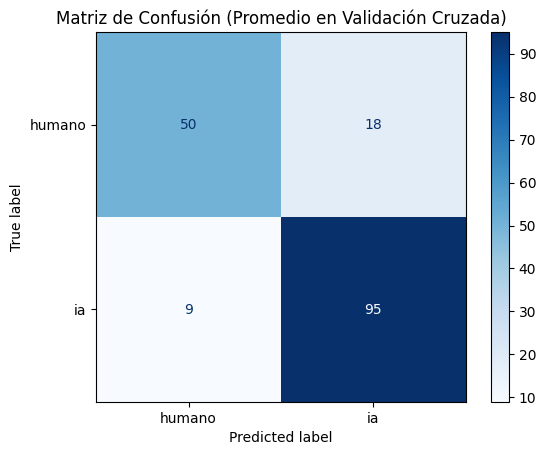

In [34]:
# -------------------------------
# Visualización de métricas y matriz de confusión
# -------------------------------
y_pred = cross_val_predict(best_model, X, y, cv=cv)

print("\nReporte de clasificación:")
print(classification_report(y, y_pred))

cm = confusion_matrix(y, y_pred, labels=best_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot(cmap='Blues')
plt.title("Matriz de Confusión (Promedio en Validación Cruzada)")
plt.show()

In [35]:
# -------------------------------
# Guardar modelo entrenado
# -------------------------------
joblib.dump(best_model, 'modelo_random_forest_entrenado_k_fold.pkl')

['modelo_random_forest_entrenado_k_fold.pkl']